<style>
    .input {
        display: none;
    }
</style>

# <div align = "Center"><u>Using Neurological Data to Predict Mouse Behavior</u></div>
### <div align="center"> Author: Aditya Vanswala </div>
#### <div align="center"> Date: March 17, 2025 </div>

---

## <div align="center" ><u> Table of Contents </u></div>
<ul>
<li> <a href = '#Abstract'>Abstract </a> </li>
<li> <a href = '#Introduction'>Introduction </a> </li>
<li> <a href = '#Exploratory Analysis'>Exploratory Analysis </a> </li>
<li> <a href = '#Data Integration'>Data Integration </a> </li>
<li> <a href = '#Predictive Modeling'>Predictive Modeling </a> </li>
<li> <a href = '#Prediction Performance'>Prediction Performance </a> </li>
<li> <a href = '#Discussion'>Discussion </a> </li>
<li> <a href = '#Apendix'>Apendix</a></li>
</ul>

---

## <div align = "center" id="Abstract"> <u>Abstract</u> </div>
> A mouse's brain consists of roughly 70 million neurons. These neurons dictates the mouse's choices, behaviors, feelings, etc., which repond to stimuli. Knowing the neuron activity will let us predict the mouse's actions, however, the vast number of neurons makes it impossible to know how every neuron responds to different stimuli. Splitting up the brain into sections and observing how a group of neurons respond to stimuli can tell us how each part of the brain contributes to the making of decisions. Understanding how the mouse's neurons respond to incoming information from different senses can help us understand how a human's brain processes new information and can predict a human's choices.

---

## <div align = "center" id="Introduction"> <u>Introduction</u> </a>
>The data we will be analyzing is a subset of data collected by Steinmetz et al. (2019). The data contains 18 sessions from 4 mice with each session having a varying number of trials. During each trial, the left and right contrast, the outcome, and the spikes of activity in neurons was tracked with each neuron having a corresponding brain area, and the spikes are recorded over 40 time intervals of 0.01 seconds each. The left and right contrast tells us the contrast on the screens the mouse was basing its decision on. If the left contrast is greater than the right contrast, then the mouse is expected to move the wheel to the left, and if the right contrast is greater, than the wheel is expected to be turned to the right. If both contrasts are 0, then the mouse is expected to not move the wheel. If both contrasts are equal, but not 0, then the mouse is expected to move the wheel in any direction to have a 50% chance of a success. With this information, we want to create a prediction model to predict the outcome of the trial based on the other available information recorded with each trial, but in order to do so, we first have to see our data.

---

## <div align = "center" id="Exploratory Analysis"> <u>Exploratory Analysis</u> </a>
> First, we will make a table of each session with relevent information such as the number of trials, neurons, average number of neuron spikes, and the success rate. What we hope to see from the table is a trend between the success rate and another variable. If we find a correlation, we can look into it further to see if it should be included in our model, or not to remove unneccessary complexity.


In [3]:
import numpy as np
import rdata
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pandas as pd

In [4]:
session=[]
for i in range(1,19):
  data = rdata.read_rds('./Data/session'+str(i)+'.rds')
  session.append(data)

# fix data to be in a better format
# change arrs from [[],...,[]] to [...]
for j in range(18):
    session[j]["date_exp"] = session[j]["date_exp"][0]
    session[j]["mouse_name"] = session[j]["mouse_name"][0]
    temp1 = np.array([])
    temp2 = np.array([])
    temp3 = np.array([])
    for i in range(len(session[j]["contrast_left"])):
        temp1 = np.append(temp1,session[j]["contrast_left"][i])
        temp2 = np.append(temp2,session[j]["contrast_right"][i])
        temp3 = np.append(temp3,session[j]["feedback_type"][i])
    session[j]["contrast_left"] = temp1
    session[j]["contrast_right"] = temp2
    session[j]["feedback_type"] = temp3


session_dict = {"Name":[], "Date":[], "Number of Trials":[], "Number of Neurons":[],"Number of Spikes":[], "Average Number of Spikes":[],"Success Rate":[]}
for i in range(18):
    session_dict["Name"] += [session[i]["mouse_name"]]
    session_dict["Date"] += [session[i]["date_exp"]]
    session_dict["Number of Trials"] += [len(session[i]["feedback_type"])]
    session_dict["Number of Neurons"] += [len(session[i]["brain_area"])]
    session_dict["Number of Spikes"] += [round(np.sum(np.array(session[i]["spks"])))]
    session_dict["Average Number of Spikes"] += [round(np.sum(np.array(session[i]["spks"])) / len(session[i]["feedback_type"]),2)]
    session_dict["Success Rate"] += [round(np.mean((session[i]["feedback_type"] + 1)/2),2)]

session_table = pd.DataFrame(session_dict)
session_table.set_index("Name")

,Date,Number of Trials,Number of Neurons,Number of Spikes,Average Number of Spikes,Success Rate
Name,,,,,,
Cori,2016-12-14,114,734,128831,1130.10,0.61
Cori,2016-12-17,251,1070,339911,1354.23,0.63
Cori,2016-12-18,228,619,315280,1382.81,0.66
Forssmann,2017-11-01,249,1769,370689,1488.71,0.67
Forssmann,2017-11-02,254,1077,305244,1201.75,0.66
Forssmann,2017-11-04,290,1169,224828,775.27,0.74
Forssmann,2017-11-05,252,584,208298,826.58,0.67
Hench,2017-06-15,250,1157,478873,1915.49,0.64
Hench,2017-06-16,372,788,465315,1250.85,0.69


>Making a table to compare the different sessions, we can see that Lederberg has the best success rate, being the only mice to pass the 80% success rate. Lederberg also has some of the lowest average number of spikes. Cori appears to be the worst being the only mice not to pass the 70% success rate, while also having some of the highest average number of spikes. In order to make the differences between the different mice's clearer, we will group the sessions together by mouse to hopefully see if the mice's have some similarites between them that we can use in our final model.

In [5]:
session_dict_by_mouse = {"Name":[], "Number of Trials":[] ,"Number of Spikes":[], "Average Number of Spikes":[],"Success Rate":[]}
def add_sessions(start, end):
    ind = len(session_dict_by_mouse["Name"])
    session_dict_by_mouse["Name"] += [session[start]["mouse_name"]]
    session_dict_by_mouse["Number of Trials"] += [len(session[start]["feedback_type"])]
    session_dict_by_mouse["Number of Spikes"] += [round(np.sum(np.array(session[start]["spks"])))]
    session_dict_by_mouse["Success Rate"] += [np.sum((session[start]["feedback_type"] + 1)/2)]
    for i in range(start + 1, end):
        session_dict_by_mouse["Number of Trials"][ind] += len(session[i]["feedback_type"])
        session_dict_by_mouse["Number of Spikes"][ind] += round(np.sum(np.array(session[i]["spks"])))
        session_dict_by_mouse["Success Rate"][ind] += np.sum((session[i]["feedback_type"] + 1)/2)
    session_dict_by_mouse["Success Rate"][ind] = round(session_dict_by_mouse["Success Rate"][ind] / session_dict_by_mouse["Number of Trials"][ind],2)
    session_dict_by_mouse["Average Number of Spikes"] += [round(session_dict_by_mouse["Number of Spikes"][ind] / session_dict_by_mouse["Number of Trials"][ind],2)]

add_sessions(0,3)
add_sessions(3,7)
add_sessions(7,11)
add_sessions(11,18)
session_table_by_mouse = pd.DataFrame(session_dict_by_mouse)
session_table_by_mouse.set_index("Name")

,Number of Trials,Number of Spikes,Average Number of Spikes,Success Rate
Name,,,,
Cori,593,784022,1322.13,0.64
Forssmann,1045,1109059,1061.30,0.69
Hench,1411,1932830,1369.83,0.68
Lederberg,2032,2308017,1135.84,0.76


>By combining the data between session for each mouse, we can confirm that the best mouse was Lederberg and the worst was Cori. One other observation we can make is that the two worst mice, Cori and Hench, have higher average number of neuron spikes than the other two mice, Lederberg and Forssmann, who have higher success rates. This suggests a negative relationship between the average number of spikes and the success rate. In order to visualize this pattern, we will make a scatter plot between the success rate and the average number of neuron spikes.

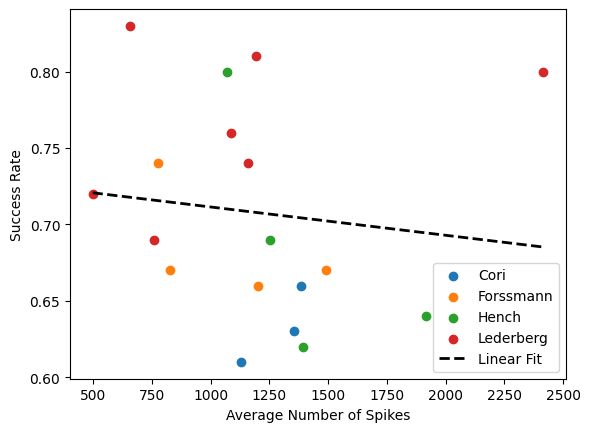

In [6]:
plt.figure()
for name in session_table["Name"].unique():
    sub_df = session_table[session_table["Name"] == name]
    plt.scatter(y = sub_df["Success Rate"], x = sub_df["Average Number of Spikes"], label = name)
m, b = np.polyfit(session_table["Average Number of Spikes"],session_table["Success Rate"], 1)  # Fit line (y = mx + b)
x = [sub_df["Average Number of Spikes"].min(), sub_df["Average Number of Spikes"].max()]
y = [m*x[0]+b, m*x[1]+b]
plt.plot(x, y, color="black", linestyle="--", linewidth=2, label="Linear Fit")
plt.xlabel("Average Number of Spikes")
plt.ylabel("Success Rate")
plt.legend()


> The plot shows that there may be a slight negative relationship between the success rate and the average number of spikes. Because of this, we may want to consider including the average number of spikes into our model to capture the relationship between the average number of spikes and the success rate. We can also look at the breakdown of the average number of spikes by plotting the average number of spikes over time for 3 trials in sessions 1 and 12. We will create 2 plots for each session to determine if there are any patterns if the mouse succeeded or failed the trial.

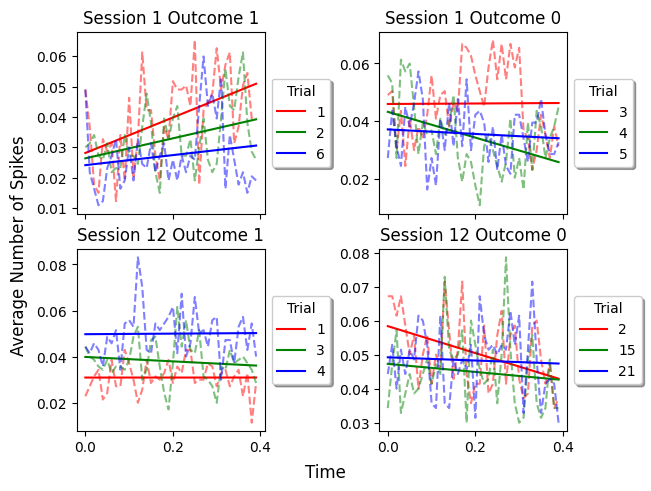

In [7]:
def get_spiks_v_t(i, trial, axes, col):
    x = session[i]["time"][trial] - session[i]["time"][trial][0]
    y = []
    for t in range(len(x)):
        count = 0
        for neuron in session[i]["spks"][trial]:
            count += neuron[t]
        y += [count / len(session[i]["brain_area"])]
    axes.plot(x,y, linestyle = "--", alpha = 0.5, color = col)
    b,c  = np.polyfit(x,y,1)
    axes.plot(x, b*x+c, color = col, label = trial + 1)





    axes.set_title(f"Session {i + 1} Outcome {int((session[i]['feedback_type'][trial] + 1 )/ 2)}")
    axes.legend(title = "Trial", loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)



fig, axes = plt.subplots(2,2, sharex = True, constrained_layout=True)
fig.supxlabel("Time")
fig.supylabel("Average Number of Spikes")
get_spiks_v_t(0, 0, axes[0,0], "red")
get_spiks_v_t(0, 1, axes[0,0], "green")
get_spiks_v_t(0, 5, axes[0,0], "blue")

get_spiks_v_t(0, 2, axes[0,1],"red")
get_spiks_v_t(0, 3, axes[0,1],"green")
get_spiks_v_t(0, 4, axes[0,1],"blue")

get_spiks_v_t(11, 0, axes[1,0],"red")
get_spiks_v_t(11, 2, axes[1,0],"green")
get_spiks_v_t(11, 3, axes[1,0],"blue")


get_spiks_v_t(11, 1, axes[1,1],"red")
get_spiks_v_t(11, 14, axes[1,1],"green")
get_spiks_v_t(11, 20, axes[1,1],"blue")

> We can observe from the plot above that the average number of spikes only seems to go down if the outcome is a fail. If the outcome is a success, the average number of spikes seems to be constant or increasing over time. We can try to include this pattern into our final model by including the average number of spikes for every time bin as a predictor for the outcome, however because some successful and unsuccessful trials have a roughly constant average number of spikes, the impact may not be significant. To dig deeper into this relationship, we can also create a histogram of the average number of spikes for successful and unsuccessful trials for each mouse. We do this to check if the distribution of the average number of spikes is different for the outcomes.

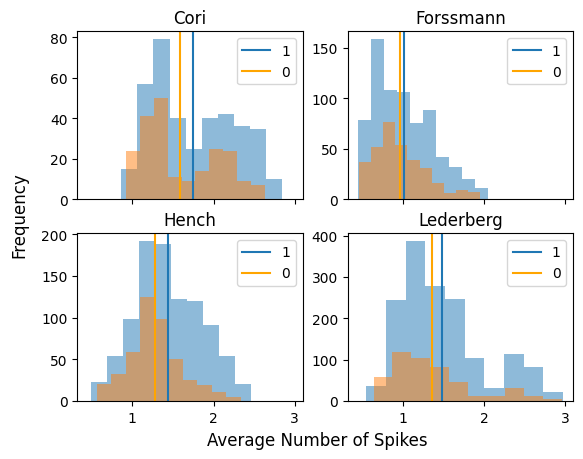

In [8]:
def hist_neurons(start, end, axes, outcome):
    y = []
    for i in range(start,end):
        for trial in range(len(session[i]["feedback_type"])):
            count = 0
            if session[i]["feedback_type"][trial] != outcome:
                continue
            count += np.sum(session[i]["spks"][trial]) /  len(session[i]["brain_area"])
            y = y + [count]
    axes.hist(y, alpha = 0.5)
    if outcome == 1:
        axes.axvline(np.mean(y), label = "1")
    else:
        axes.axvline(np.mean(y), color = "orange", label = "0")
    axes.legend()
    axes.set_title(session[start]["mouse_name"])

fig, axes = plt.subplots(2,2, sharex = True)
fig.supxlabel("Average Number of Spikes")
fig.supylabel("Frequency")

hist_neurons(0,3, axes[0,0], 1)
hist_neurons(3,7, axes[0,1], 1)
hist_neurons(7,11, axes[1,0], 1)
hist_neurons(11,18, axes[1,1], 1)

hist_neurons(0,3, axes[0,0], -1)
hist_neurons(3,7, axes[0,1], -1)
hist_neurons(7,11, axes[1,0], -1)
hist_neurons(11,18, axes[1,1], -1)

> We can see that for every mouse, the mean of the distribution of the average number of spikes for a successful trial is greater than the mean for the distribution of the unsuccessful trials. This is another reason why we may want to include the average number of spikes into our prediction model. To see if there is a relationship between the trial number and the success rate, we can divide each session up into 6 equal parts and plot the success rate for each section. We divide the sessions up to hopefully see if the success rate changes in different sections of each session.

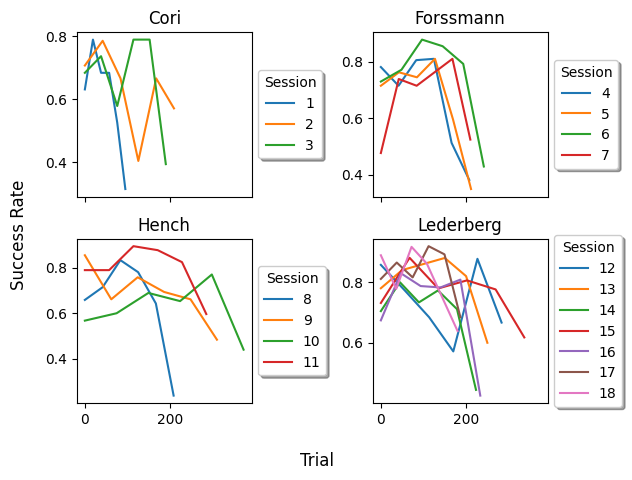

In [9]:
def plot_suc_vs_tri(start, end, div, axes):
    for j in range(start, end):
        groups = np.linspace(0, len(session[j]["feedback_type"]), div+1)
        x = groups[:len(groups)-1]
        y = []
        for i in range(len(x)):
            y += [(sum((session[j]["feedback_type"][int(groups[i]):int(groups[i+1])] + 1) / 2)) / (int(groups[i+1])- int(groups[i]))]
        axes.set_title(session[j]["mouse_name"])
        axes.plot(x,y, label = j + 1)
    axes.legend(title = "Session", loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

fig, axes = plt.subplots(2,2, sharex=True, tight_layout = True)
fig.supylabel("Success Rate")
fig.supxlabel("Trial")

Sections = 6
plot_suc_vs_tri(0,3,Sections,axes[0,0])
plot_suc_vs_tri(3,7,Sections,axes[0,1])
plot_suc_vs_tri(7,11,Sections,axes[1,0])
plot_suc_vs_tri(11,18,Sections,axes[1,1])

> By splitting the data into 6 parts, we can observe that as the number of trials increases, the mouse appears to perform better, and then worse. The initial increase in success rate can be explained by the mouse learning the correct choice as the trial goes on. The eventual decrease could be attributed to the mouse getting tired as the number of trials increases. To capture this pattern in our model, we can include the trial number in our prediction model. We can also investigate if the left and right contrasts affect the success rates by creating heatmaps for each mouse.

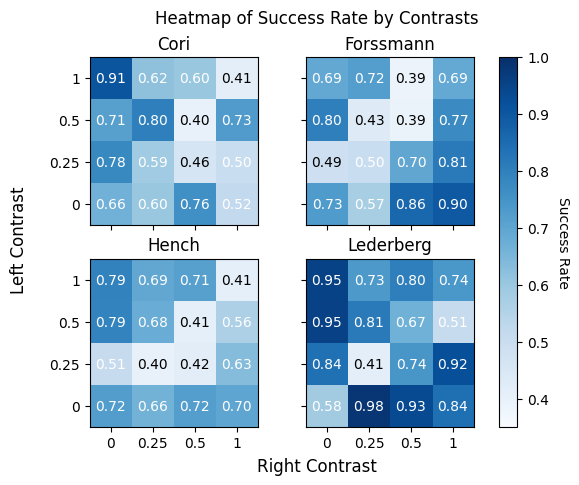

In [10]:
contrast_left_val = [1, 0.5, .25, 0]
contrast_right_val = [0, 0.25, .5, 1]

def get_data(start, end):
    values = []
    for i in range(len(contrast_left_val)):
        values = values + [[]]
        for j in range(len(contrast_right_val)):
            result = np.array([])
            for k in range(start, end):
                contrast_left_ind = session[k]["contrast_left"] == contrast_left_val[i]
                contrast_right_ind = session[k]["contrast_right"] == contrast_right_val[j]
                ind = np.logical_and(contrast_left_ind, contrast_right_ind)
                result = np.append(result, (np.array(session[k]["feedback_type"])[ind] + 1)/2)
            avg = sum(result) / len(result)
            values[i] = values[i] + [avg]
    return values

# Function to make heatmaps
def plot_heatmap(start, end, ax, cmap, title):
    data = get_data(start, end)
    im = ax.imshow(data, cmap=cmap, vmin = .35, vmax = 1)
    ax.set_title(title)
    for i in range(len(data)):
        for j in range(len(data[0])):
            ax.text(j, i, f"{data[i][j]:.2f}", ha='center', va='center', color='black' if data[i][j] < 0.5 else 'white')
    return im

fig, axes = plt.subplots(2,2, sharex = True, sharey = True)
fig.supylabel("Left Contrast")
fig.supxlabel("Right Contrast")
fig.suptitle("Heatmap of Success Rate by Contrasts")
axes[0,0].set_xticks([0,1,2,3])
axes[0,0].set_yticks([0,1,2,3])
axes[0,0].set_xticklabels(contrast_right_val)
axes[0,0].set_yticklabels(contrast_left_val)
# Heatmap for Cori
plot_heatmap(0, 3, axes[0,0], "Blues", "Cori")

# Heatmap for Forssmann
plot_heatmap(3, 7, axes[0,1], "Blues", "Forssmann")

# Heatmap for Hench
plot_heatmap(7, 11, axes[1,0], "Blues", "Hench")

# Heatmap for Lederberg
im = plot_heatmap(11, 18, axes[1,1], "Blues", "Lederberg")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label('Success Rate', rotation=270, labelpad=15)


> We can observe from these plots that some mice have a bias for when one contrast is higher than the other. This can be seen in Cori and Hench's heatmaps, where they perfrom better when the left contrast is higher than the right contrast. For Forssmann, the mouse appears to perfom better when the right contrast is bigger than the left. Some of the error in our final model may be accounted for by the preference of one side over the other for each mouse. The heatmaps also shows that the mice perform better when the left and right contrasts are on opposite extremes. For example, Cori has a success rate of 0.91 when the left contrast is 1 and the right contrast is 0. We can visualize this pattern by creating a plot of the success rate vs the difference in contrasts.

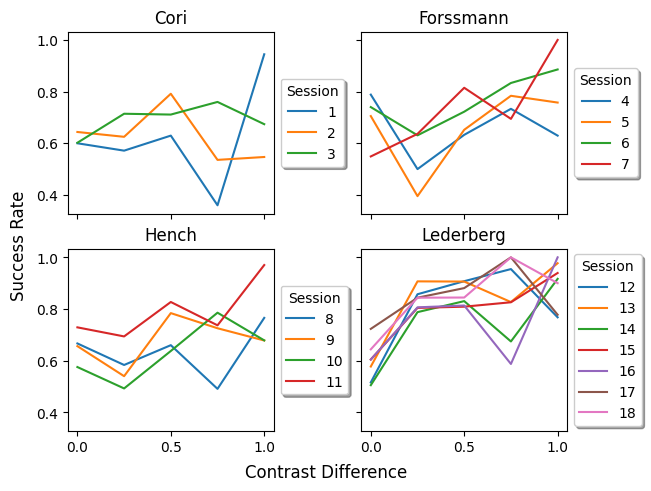

In [11]:
def plot_succ_vs_diff(start, end, axes):
    x = [0, .25, .5 , .75, 1]
    for sess in range(start, end):
        y = []
        for diff in x:
            ind = abs(session[sess]["contrast_left"] - session[sess]["contrast_right"]) == diff
            arr = (session[sess]["feedback_type"][ind]+1) / 2
            y += [np.mean(arr)]
        axes.plot(x,y, label = sess + 1)
    axes.legend(title = "Session", loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    axes.set_title(session[start]["mouse_name"])
        

fig, axes = plt.subplots(2,2, sharex = True, sharey = True, constrained_layout = True)
fig.supxlabel("Contrast Difference")
fig.supylabel("Success Rate")
plot_succ_vs_diff(0,3, axes[0,0])
plot_succ_vs_diff(3,7, axes[0,1])
plot_succ_vs_diff(7,11, axes[1,0])
plot_succ_vs_diff(11,18, axes[1,1])

> For all mice, there seems to be a positive relationship between the success rate and the difference in the left and right contrasts. This is to be expected because we can intuitively understand that the mice would perform better when the contrasts are the furthest apart. We can try to capture this relationship by adding a variable for the difference in contrasts. At this point, the model is fairly complex, so we can try to use Principle Component Analysis to hopefully reduce the number of predictors while trying to explain as much variance of the response variable as possible.

---

## <div align = "center" id="Data Integration"> <u>Data Integration</u> </a>

> To create a prediction model, we will create a table of our predictors for every trial in every session together. Even though the mice have different neuron activity, we combine all results for every session because we would have significantly more trials to include into our model. The predictors of our model are the session number (treated as a categorical variable), trial number, left and right contrast, the difference in the contrast (treated as a categorical variable), the average number of spikes for each time bin, and a variable that is 1 if the two contrasts are equal, but non-zero to account for the case when the mouse has a 50% chance of success or failure when moving the wheel in either direction. For sessions 1 and 18, because 100 trials were randomly removed to be the test data, we will spread out the trial number to account for the removed data. To find the best model, we will split the data into two, 80% will be used to train the data, and the other 20% will be used to test our models and pick the best one.

> To reduce the complexity of the model, we can try to use PCA to reduce the number of predictors in our model. To see the number of principle components we would need for the model, we can plot the explained variance of each component.

In [29]:
predictor_dict = {"Session":[], "Trial_Num":[], "Contrast_Right":[], "Contrast_Left":[], "Diff":[]}
y = []

for t in range(40):
    predictor_dict[f"Avg_Spks_{t}"] = []

for sess in range(18):
    y += (session[sess]["feedback_type"] == 1).tolist()
    predictor_dict["Session"] += (np.repeat(sess, len(session[sess]["feedback_type"])) + 1).tolist()
    if (sess == 0) | (sess == 17):
        predictor_dict["Trial_Num"] += np.floor(np.linspace(1, len(session[sess]["feedback_type"]) + 101, len(session[sess]["feedback_type"]))).tolist()
    else:
        predictor_dict["Trial_Num"] += range(1, len(session[sess]["feedback_type"]) + 1)
    
    predictor_dict["Contrast_Right"] += session[sess]["contrast_right"].tolist()
    predictor_dict["Contrast_Left"] += session[sess]["contrast_left"].tolist()
    predictor_dict["Diff"] += abs(session[sess]["contrast_right"] - session[sess]["contrast_left"]).tolist()
    
    for trial in range(len(session[sess]["feedback_type"])):
        #predictor_dict["Avg_Spks"] += [np.mean(session[sess]["spks"][trial])]
        arr_avg = np.mean(session[sess]["spks"][trial], axis = 0)
        for t in range(40):
            predictor_dict[f"Avg_Spks_{t}"] += [arr_avg[t]]
ind = np.logical_and(np.array(predictor_dict["Contrast_Right"]) == np.array(predictor_dict["Contrast_Left"]), np.array(predictor_dict["Contrast_Right"]) != 0)
predictor_dict["Rand"] = ind.astype(int)
x = pd.DataFrame(predictor_dict)
df_encoded = pd.get_dummies(x, columns=['Session'], drop_first=True).astype(float)
df_encoded = pd.get_dummies(df_encoded, columns=['Diff'], drop_first=True).astype(float)



In [13]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_encoded, y, test_size=0.2, random_state=7999)
# X_train = df_encoded
# y_train = y

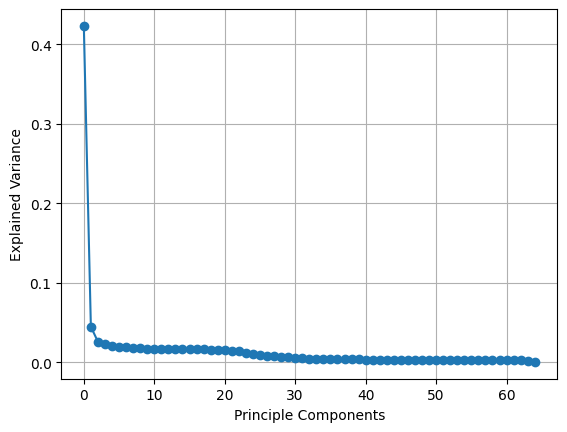

In [14]:
scaler = sklearn.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = sklearn.decomposition.PCA()
pca.fit(X_scaled)

plt.plot(pca.explained_variance_ratio_, marker='o')
plt.xlabel("Principle Components")
plt.ylabel("Explained Variance")
plt.grid()
plt.show()

> We can see that the first 2 components explain the most variance. To see if PCA is a good choice, we can plot the PCA transformed data. We hope to see a clear distinction between the trials that are successful and unsuccessful using the principle components.

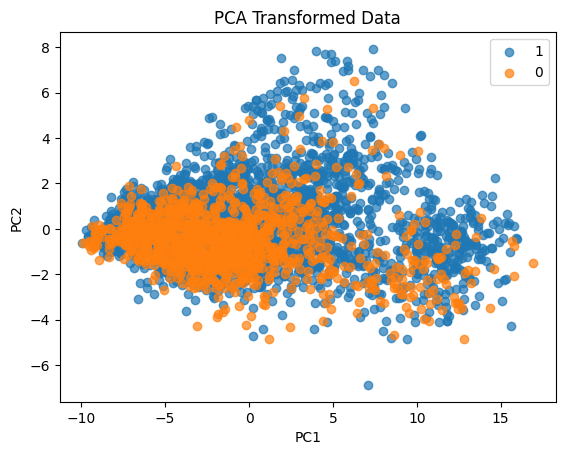

In [15]:
pca = sklearn.decomposition.PCA()
X_pca = pca.fit_transform(X_scaled)

X_pca_1 = X_pca[y_train]
X_pca_0 = X_pca[np.logical_not(y_train)]

plt.figure()
plt.scatter(X_pca_1[:, 0], X_pca_1[:, 1], alpha=0.7, label = 1)
plt.scatter(X_pca_0[:, 0], X_pca_0[:, 1], alpha=0.7, label = 0)
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Transformed Data")
plt.show()

> Because the successful and unsuccessful trials are overlapping significantly, PCA is not a good option for this data set. We will continue to use the 65 variables we had previously by integrating all of the data from every session together. 

---

## <div align = "center" id="Predictive Modeling"> <u>Predictive Modeling</u> </a>

> To create a prediction model using the training data, we will use the sklearn library to create 2 models. One using logistic regression with L1 regularization (Lasso) and the other using linear discriminant analysis. We will also be using XGBoost to create a model. Once we have our models, we will use them to predict the other 20% of our data that we reserved to pick the best model. 

> The logistic regression works by computing the cost function (Log Loss) and adding the L1 regularization term to penalize large coefficients. By optimizing the function while shrinking some coefficients to zero, the final model will only include the important features, reducing the overall complexity.

> Linear discriminant analysis works by finding the direction that best seperates the success trials from the unsuccessful trials. This is similar to PCA, but PCA focuses on the direction of maximum variance. This method often reduces dimensions which can help reduce the complexity of a model; however, this method works best for data that have a clear seperation between each class. Our data does not appear to have a clear seperation, so we expect this model to perform the worst. 

> XGBoost uses decision trees to update its predictions using the training data. It starts with a weak tree and starts adding more trees to reduce the errors until it reaches optimal performance. XGBoost also prevents overfitting using regularization.

> With these 3 models, after training them with 80% of the data and testing them with the remaining 20, we get the following accuracy scores.

In [16]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear') 
model.fit(X_train, y_train)

coef = model.coef_[0]

# for i in range(len(coef)):
#     if coef[i] == 0:
#         continue
#     print(X_train.columns[i], coef[i])

In [17]:
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
temp = lda.fit(X_train, y_train)

# pd.DataFrame(lda.means_, columns=X_train.columns, index=[1,-1])

In [18]:
predictor_XGB = xgb.DMatrix(X_train, label=y_train)
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.1,
    'eval_metric': 'logloss'
}
XBG_model = xgb.train(params, predictor_XGB, num_boost_round=100)

In [19]:
model_table = {"Model":[], "Accuracy":[]}

y_pred_lda = lda.predict(X_test)
model_table["Model"] += ["LDA"]
model_table["Accuracy"] += [sklearn.metrics.accuracy_score(y_test, y_pred_lda)]
#print(sklearn.metrics.confusion_matrix(y_test, y_pred_lda))

y_pred_logit = model.predict(X_test)
model_table["Model"] += ["L1"]
model_table["Accuracy"] += [sklearn.metrics.accuracy_score(y_test, y_pred_logit)]
#print(sklearn.metrics.confusion_matrix(y_test, y_pred_logit))

test_XGB = xgb.DMatrix(X_test, label=y_test)
y_pred_prob = XBG_model.predict(test_XGB)
y_pred_XGB = [1 if prob > 0.5 else 0 for prob in y_pred_prob]
model_table["Model"] += ["XGBoost"]
model_table["Accuracy"] += [sklearn.metrics.accuracy_score(y_test, y_pred_XGB)]
#print(sklearn.metrics.confusion_matrix(y_test, y_pred_XGB))

pd.DataFrame(model_table).set_index("Model")


,Accuracy
Model,
LDA,0.724680
L1,0.730580
XGBoost,0.737463


> Looking at the accuracy of the 3 models, we can see that the best performing model was XGBoost, with the Logistic Regression model following closely behind. The final model we will use to predict the test data from session 1 and 18 will be the XGBoost model.

---

## <div align = "center" id="Prediction Performance"> <u>Prediction Performance</u> </a>

In [20]:
test_session=[]
for i in range(1,3):
  data = rdata.read_rds('./Data/test'+str(i)+'.rds')
  test_session.append(data)

# fix data to be in a better format
# change arrs from [[],...,[]] to [...]
for j in range(2):
    test_session[j]["date_exp"] = test_session[j]["date_exp"][0]
    test_session[j]["mouse_name"] = test_session[j]["mouse_name"][0]
    temp1 = np.array([])
    temp2 = np.array([])
    temp3 = np.array([])
    for i in range(len(test_session[j]["contrast_left"])):
        temp1 = np.append(temp1,test_session[j]["contrast_left"][i])
        temp2 = np.append(temp2,test_session[j]["contrast_right"][i])
        temp3 = np.append(temp3,test_session[j]["feedback_type"][i])
    test_session[j]["contrast_left"] = temp1
    test_session[j]["contrast_right"] = temp2
    test_session[j]["feedback_type"] = temp3

In [21]:
test_dict = {"Session":[], "Trial_Num":[], "Contrast_Right":[], "Contrast_Left":[], "Diff":[]}
y_true = []
for t in range(40):
    test_dict[f"Avg_Spks_{t}"] = []

test_dict["Session"] += np.repeat(1, len(test_session[0]["feedback_type"])).tolist()
test_dict["Session"] += np.repeat(18, len(test_session[1]["feedback_type"])).tolist()

test_dict["Trial_Num"] += np.floor(np.linspace(1, len(session[0]["feedback_type"]) + 100, len(test_session[0]["feedback_type"]))).tolist()
test_dict["Trial_Num"] += np.floor(np.linspace(1, len(session[17]["feedback_type"]) + 100, len(test_session[1]["feedback_type"]))).tolist()

for sess in range(2):
    y_true += (test_session[sess]["feedback_type"] == 1).tolist()
    test_dict["Contrast_Right"] += test_session[sess]["contrast_right"].tolist()
    test_dict["Contrast_Left"] += test_session[sess]["contrast_left"].tolist()
    test_dict["Diff"] += abs(test_session[sess]["contrast_right"] - test_session[sess]["contrast_left"]).tolist()
    
    for trial in range(len(test_session[sess]["feedback_type"])):
        #predictor_dict["Avg_Spks"] += [np.mean(session[sess]["spks"][trial])]
        arr_avg = np.mean(test_session[sess]["spks"][trial], axis = 0)
        for t in range(40):
            test_dict[f"Avg_Spks_{t}"] += [arr_avg[t]]

ind = np.logical_and(np.array(test_dict["Contrast_Right"]) == np.array(test_dict["Contrast_Left"]), np.array(test_dict["Contrast_Right"]) != 0)
test_dict["Rand"] = ind.astype(int)

for i in range(2,18):
    test_dict[f"Session_{i}"] = np.repeat(0, len(test_dict["Session"]))

test_x = pd.DataFrame(test_dict)
# ind = np.logical_or(np.array(test_dict["Contrast_Right"]) != np.array(test_dict["Contrast_Left"]), np.array(test_dict["Contrast_Right"]) == 0)
# test_x = test_x.iloc[ind]
# y_true = np.array(y_true)[ind].tolist()

test_df_encoded = pd.get_dummies(test_x, columns=['Session'], drop_first=True).astype(float)
test_df_encoded = pd.get_dummies(test_df_encoded, columns=['Diff'], drop_first=True).astype(float)
# test_df_encoded = pd.get_dummies(test_df_encoded, columns=['Contrast_Right'], drop_first=True).astype(float)
# test_df_encoded = pd.get_dummies(test_df_encoded, columns=['Contrast_Left'], drop_first=True).astype(float)

test_df_encoded1 = test_df_encoded.iloc[range(100)]
test_df_encoded2 = test_df_encoded.iloc[range(100,200)]
y_true1 = np.array(y_true)[range(100)]
y_true2 = np.array(y_true)[range(100,200)]

In [22]:
test_XGB = xgb.DMatrix(test_df_encoded, label=y_true)
y_pred_prob = XBG_model.predict(test_XGB)
y_pred_XGB = [1 if prob > 0.5 else 0 for prob in y_pred_prob]
# print(sklearn.metrics.accuracy_score(y_true, y_pred_XGB))
# print(sklearn.metrics.confusion_matrix(y_true, y_pred_XGB))

> After preparing our test data by creating the different predictor variables and spreading out the trial number to account for the random selection from the sessions, we got an accuracy 75%. To see the missclassification errors, we can make a confusion matrix.

In [26]:
matrix =sklearn.metrics.confusion_matrix(y_true, y_pred_XGB)
cm_table = {"Prediction":[0,1], "True 0":[], "True 1":[]}
cm_table["True 0"] = [matrix[0][0], matrix[0][1]]
cm_table["True 1"] = [matrix[1][0], matrix[1][1]]
pd.DataFrame(cm_table).set_index("Prediction")

,True 0,True 1
Prediction,,
0,6,1
1,49,144


The confusion matrix shows that we incorrectly classified 1 trial as a success, and 49 trials as a fail, while correctly predicting the other 150 trials.

---

## <div align = "center" id="Discussion"> <u>Discussion</u> </a>

> Our final model correctly predicted 150 out of 200 trials. Some errors in our model can be explained by the difference in brain activity for each mouse, and errors in our model can arise from the trials where the left and right contrasts are the same, but not zero. In these trials, the mouse has a 50% chance of a success when moving the wheel in either direction. Our model has an accuracy of 0.75, while the no information rate (predicting only sucesses) is 0.725, meaning that our model could be higher than the NIR due to chance alone, and no information was gained from the data. A few ways we could improve our model is by looking at more variables from the whole dataset. We only looked at a subset of the data collected from the trials. Some additional information in the full dataset includes pupil area, position, and more timebins for each trial.


---

## <div align = "center" id="Apendix"> <u>Apendix</u> </a>